# 测量对象之间的距离
这个笔记本演示了如何测量一个图像中的对象到另一个图像中最近对象的距离。这种方法的一个用例是测量诸如细胞之类的对象到血管的距离。以下程序在2D中演示，并且应该可以类似地在3D中工作。

In [1]:
import numpy as np
import pyclesperanto_prototype as cle
import napari_simpleitk_image_processing as nsitk
import pandas as pd

作为示例数据，我们使用两个合成图像：一个二值图像显示血管作为条纹的位置，以及一个标签图像显示细胞/对象的位置。

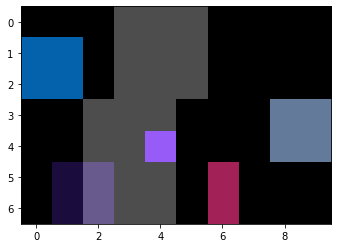

In [2]:
vessel = np.asarray([
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
])

objects = np.asarray([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5, 5],
    [0, 0, 0, 0, 2, 0, 0, 0, 5, 5],
    [0, 4, 4, 0, 0, 0, 3, 0, 0, 0],
    [0, 4, 4, 0, 0, 0, 3, 0, 0, 0],
])

cle.imshow(vessel, continue_drawing=True)
cle.imshow(objects, labels=True, alpha=0.7)

## 距离图
为了测量标记像素到其他对象的平均距离，一种策略涉及[距离图](https://en.wikipedia.org/wiki/Distance_transform)。这里我们使用[SimpleITK](https://simpleitk.readthedocs.io/)中实现的[有符号Maurer距离图](https://itk.org/ITKExamples/src/Filtering/DistanceMap/MaurerDistanceMapOfBinary/Documentation.html)。更准确地说，我们使用可脚本化的napari插件[napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing)来访问该图。如果值为正，我们在血管外部。负值表示我们在内部。

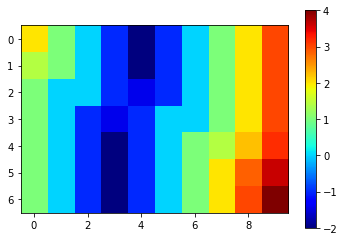

In [3]:
not_vessel = cle.binary_not(vessel)

distance_from_vessel = nsitk.signed_maurer_distance_map(not_vessel)

cle.imshow(distance_from_vessel, colorbar=True, colormap="jet")

## 对象距离图
接下来，我们测量对象所在位置的距离图中的平均强度。这些强度代表了这些对象到血管的平均距离。根据定义，这些图中的背景强度（在我们的例子中是距离）为0。

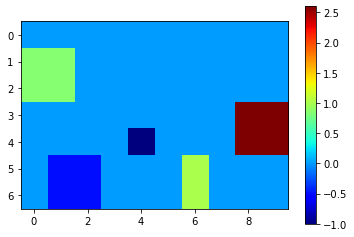

In [4]:
mean_distance_map = cle.mean_intensity_map(distance_from_vessel, objects)

cle.imshow(mean_distance_map, colorbar=True, colormap="jet")

除了这种可视化之外，我们还可以使用像素统计读取平均距离，并使用[pandas数据框](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)将它们打印出来。

In [5]:
statistics = cle.statistics_of_labelled_pixels(distance_from_vessel, objects)

table = pd.DataFrame(statistics)
table = table[['label', 'mean_intensity']]
table = table.rename(columns={'mean_intensity':'mean_distance'})

table

label  mean_distance
0      1       0.853553
1      2      -1.000000
2      3       1.000000
3      4      -0.500000
4      5       2.599586

## 过滤对象
你还可以根据对象到血管的距离来过滤对象。

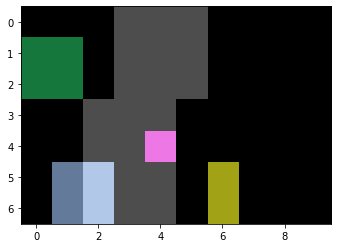

In [6]:
min_distance = -4
max_distance = 2
objects_close_by_vessel = cle.exclude_labels_with_map_values_out_of_range(
    mean_distance_map,
    objects,
    minimum_value_range=min_distance,
    maximum_value_range=max_distance
)

cle.imshow(vessel, continue_drawing=True)
cle.imshow(objects_close_by_vessel, labels=True, alpha=0.7)